# Time Series Forecasting 2

**Libraries**

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Read 

In [9]:
df = pd.read_csv('PJME_hourly.csv', index_col='Datetime')
df.index = pd.to_datetime(df.index)

In [10]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [11]:
df.shape

(145366, 1)

In [19]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

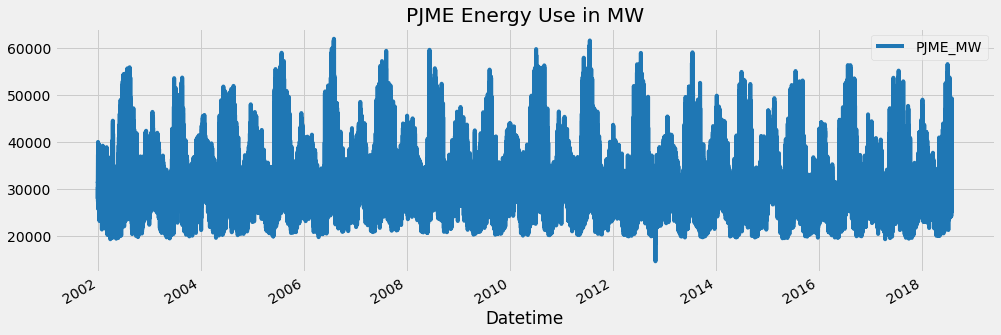

In [22]:
df.plot(figsize = (15,5),color = color_pal[0] ,title= 'PJME Energy Use in MW')
plt.show()

## Outlaier Analysis 

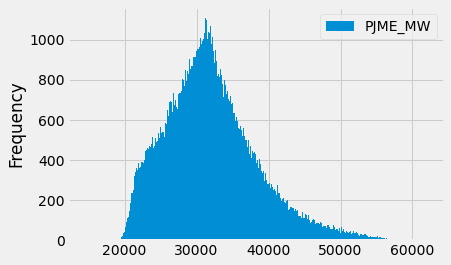

In [30]:
df.plot(kind = 'hist', bins = 500);

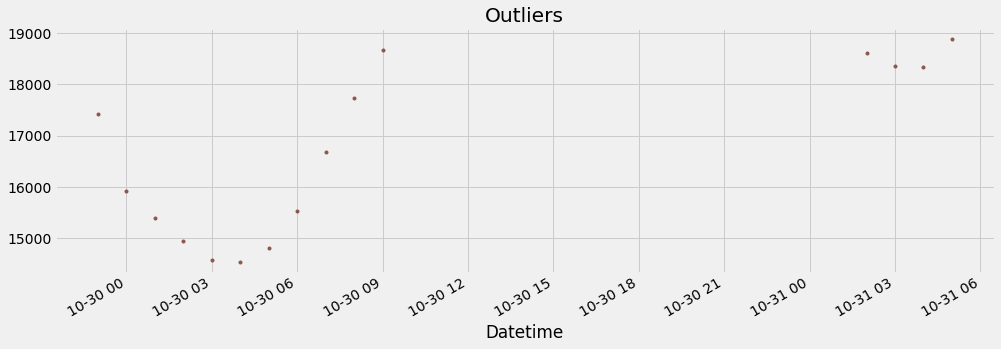

In [35]:
df.query('PJME_MW < 19_000')['PJME_MW']\
.plot(figsize = [15,5] ,style = '.',color = color_pal[5],title= 'Outliers')
plt.show()

In [37]:
#Remove outliers

data = df.query('PJME_MW > 19_000').copy()

In [38]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [39]:
data.shape

(145351, 1)

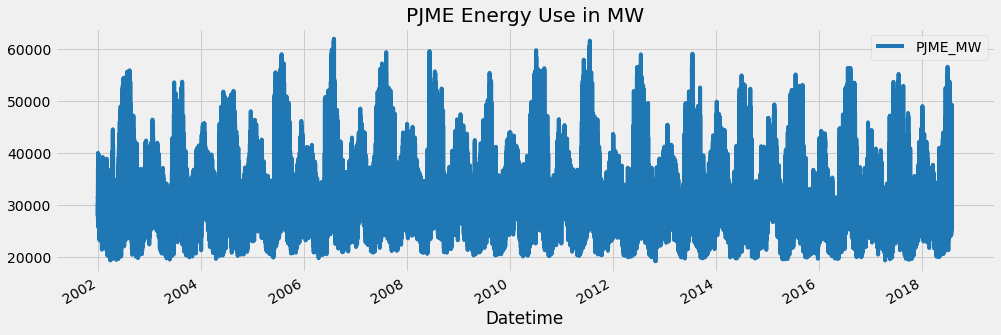

In [40]:
data.plot(figsize = (15,5),color = color_pal[0] ,title= 'PJME Energy Use in MW')
plt.show()

## train/test

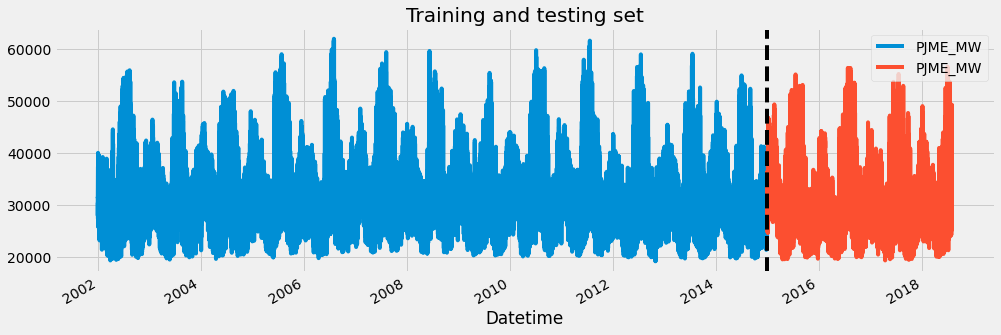

In [44]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index > '01-01-2015']

fig, ax = plt.subplots(figsize = [15,5])
train.plot( ax = ax, label = 'Trainingset')
test.plot( ax = ax, label ='Testset')

ax.axvline('01-01-2015', color = 'black', ls = '--')

plt.title('Training and testing set')
plt.legend()
plt.show()

## Time cross validation

In [45]:
from sklearn.model_selection import TimeSeriesSplit

In [46]:
tss = TimeSeriesSplit(test_size=24*365*1, gap=24)

In [48]:
#sort index
data = data.sort_index()

## Plot cross val

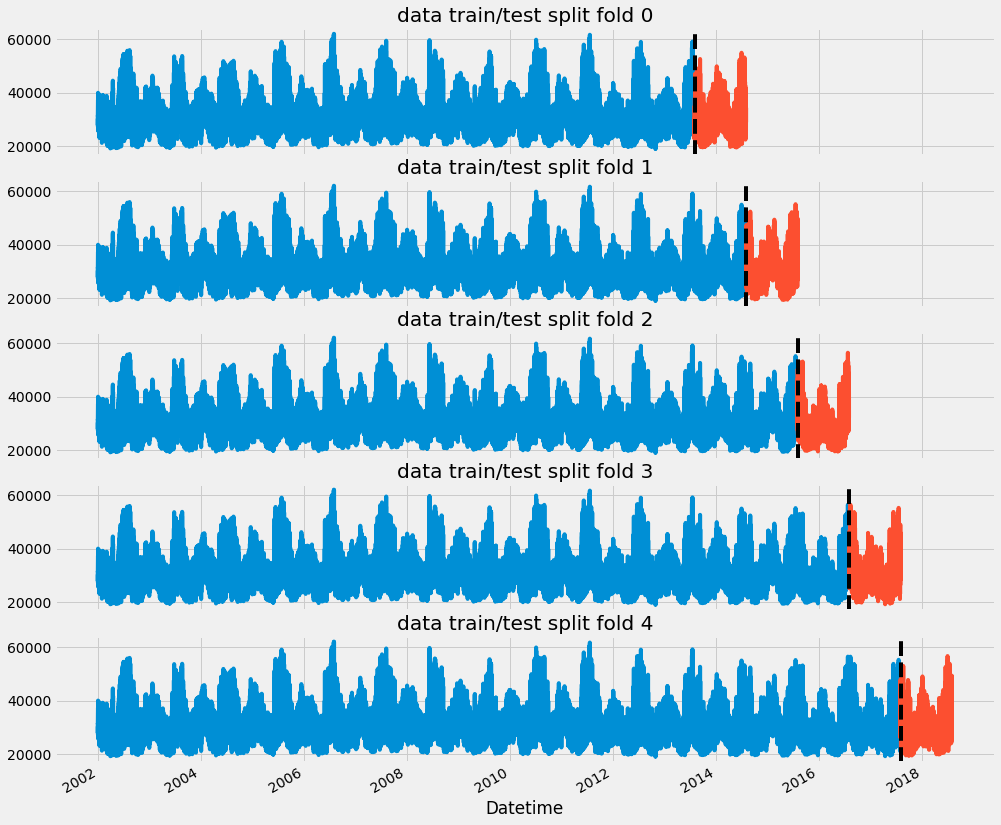

In [52]:
fig, axs = plt.subplots(5,1, figsize = (15,15), sharex = True)

fold = 0

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    
    train["PJME_MW"].plot(ax = axs[fold], label = 'Training Set', title = f'data train/test split fold {fold}')
    test["PJME_MW"].plot(ax = axs[fold], label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold +=1
plt.show()

## Forecasting 

### Data Preprocessing

In [57]:
def create_fetures(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayoyear'] = df.index.day_of_year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    return df

In [58]:
df = create_fetures(data)

In [59]:
df.head(2)

,PJME_MW,hour,year,month,quarter,dayoyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,2002,1,1,1,1,1
2002-01-01 02:00:00,29265.0,2,2002,1,1,1,1,1


### Lag featues

In [65]:
def add_lags(df):
    
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index-pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index-pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index-pd.Timedelta('1092 days')).map(target_map)
    
    return df

In [67]:
df.columns

Index(['PJME_MW', 'hour', 'year', 'month', 'quarter', 'dayoyear', 'dayofmonth',
       'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

### Cross validations

In [71]:
tss = TimeSeriesSplit(test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    
    #call function for data preprocessing
    train = create_fetures(train)
    test = create_fetures(test)
    
    #variables and target
    FEATURES = ['hour', 'year', 'month', 'quarter', 'dayoyear', 'dayofmonth',
       'weekofyear', 'lag1', 'lag2', 'lag3']
    
    TARGERT = ['PJME_MW']
    
    
    #split into X_train/X_test/y_train/y_train
    X_train = train[FEATURES]
    X_test = test[FEATURES]
    
    y_train = train[TARGERT]
    y_test = test[TARGERT]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                          n_estimators = 1000,
                          early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, eval_set =[(X_train, y_train), (X_test, y_test)], 
           verbose = 100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32732.52148	validation_1-rmse:31956.66211
[100]	validation_0-rmse:12532.10059	validation_1-rmse:11906.29785
[200]	validation_0-rmse:5757.59082	validation_1-rmse:5376.89062
[300]	validation_0-rmse:3891.23975	validation_1-rmse:3953.19849
[400]	validation_0-rmse:3475.67432	validation_1-rmse:3816.47021
[500]	validation_0-rmse:3363.97217	validation_1-rmse:3828.27856
[600]	v

In [74]:
print('Scores across fold {}'.format(np.mean(scores).round(2)))
print('Fold scores {}'.format(scores))

Scores across fold 3861.52
Fold scores [3815.1176679572914, 3449.647284513022, 3840.9680382497436, 4065.135413510426, 4136.711314353555]


## Predict the Future

In [76]:
X  = df[FEATURES]
y = df[TARGERT]

In [78]:
model =  xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                          n_estimators = 1000,
                          early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

model.fit(X, y, eval_set = [(X,y)], verbose = 100)

[15:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32403.91992
[100]	validation_0-rmse:12426.40039
[200]	validation_0-rmse:5751.82422
[300]	validation_0-rmse:3972.66187
[400]	validation_0-rmse:3583.26538
[500]	validation_0-rmse:3478.53540
[600]	validation_0-rmse:3434.13428
[700]	validation_0-rmse:3404.18677
[800]	validation_0-rmse:3377.54761
[900]	validation_0-rmse:3352.59668
[999]	validation_0-rmse:3329.46777


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [79]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [80]:
# create a  future dataframe

future =  pd.date_range(start='2018-08-03',end= '2019-08-01', freq='1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False

df1 = pd.concat([df, future_df])

#call the function to make the new columns(lag1.....)

df_all = create_fetures(df1)

In [81]:
df_all.head(2)

,PJME_MW,hour,year,month,quarter,dayoyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,2002,1,1,1,1,1,NaN,NaN,NaN,False


In [83]:
df_all.shape

(154064, 12)

In [84]:
#filter data
unseen_data = df_all.query('isFuture').copy()

#### Predictions

In [85]:
unseen_data['pred'] = reg.predict(unseen_data[FEATURES])

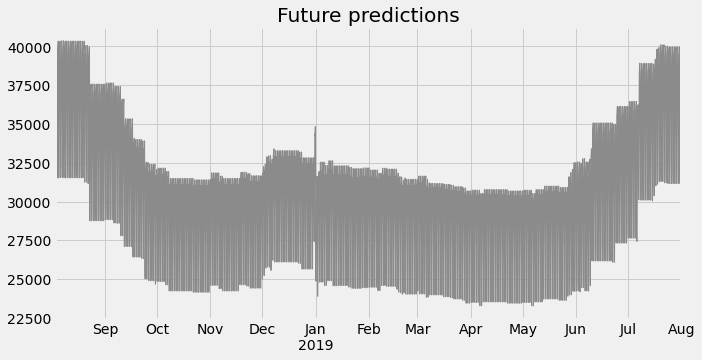

In [86]:
unseen_data['pred'].plot(figsize = [10,5],
                        color = color_pal[4],
                        ms = 1,
                        lw = 1,
                        title = 'Future predictions')
plt.show()

### Saving 

In [87]:
reg.save_model('model.json')